In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = "/kaggle/input/brytserc/"
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7 
SAMPLE_RATE = 16000
DURATION = 3  
N_MELS = 128 
N_FFT = 2048
HOP_LENGTH = 512

Using device: cuda


In [ ]:
def extract_mel_spectrogram(audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

class CNNEmotionDataset(Dataset):
   
    def __init__(self, audio_files, labels, sample_rate=SAMPLE_RATE, duration=DURATION):
        self.audio_files = audio_files
        self.labels = labels
        self.sample_rate = sample_rate
        self.duration = duration
        self.max_length = sample_rate * duration
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):

        audio = self.audio_files[idx]
        label = self.labels[idx]
        
        
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            audio = np.pad(audio, (0, self.max_length - len(audio)), mode='constant')
        
 
        mel_spec = extract_mel_spectrogram(audio)
        
   
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)
        
   
        mel_spec = np.expand_dims(mel_spec, axis=0)
        
        return {
            'spectrogram': torch.FloatTensor(mel_spec),
            'label': torch.LongTensor([label])[0]
        }

def cnn_collate_fn(batch):    
    spectrograms = torch.stack([item['spectrogram'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'spectrogram': spectrograms,
        'labels': labels
    }

In [ ]:
def load_emotion_data_cnn(data_path):
    all_features = []
    all_labels = []
    
    print("Loading data for CNN...")
    
 
    all_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
    print(f"Found {len(all_files)} audio files")
    
    if len(all_files) == 0:
        raise ValueError(f"No .wav files found in {data_path}")
    

    emotion_counts = {emotion: 0 for emotion in EMOTIONS}
    
    for file in tqdm(all_files, desc="Loading audio files"):
        try:            
            emotion_name = file.split('_')[0].lower()                        
            if emotion_name not in [e.lower() for e in EMOTIONS]:
                print(f"Warning: Unknown emotion '{emotion_name}' in file {file}")
                continue
            
        
            emotion_idx = [e.lower() for e in EMOTIONS].index(emotion_name)
            
 
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            all_features.append(audio)
            all_labels.append(emotion_idx)
            emotion_counts[EMOTIONS[emotion_idx]] += 1
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
    
    print("\nEmotion distribution:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count}")
    
    return all_features, np.array(all_labels)


features, labels = load_emotion_data_cnn(DATA_PATH)
print(f"\nTotal samples: {len(labels)}")

if len(labels) == 0:
    raise ValueError("No data loaded! Please check your data path and file format.")

print(f"Label distribution: {np.bincount(labels)}")


X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.4, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain samples: {len(y_train)} ({len(y_train)/len(labels)*100:.1f}%)")
print(f"Validation samples: {len(y_val)} ({len(y_val)/len(labels)*100:.1f}%)")
print(f"Test samples: {len(y_test)} ({len(y_test)/len(labels)*100:.1f}%)")

train_dataset = CNNEmotionDataset(X_train, y_train)
val_dataset = CNNEmotionDataset(X_val, y_val)
test_dataset = CNNEmotionDataset(X_test, y_test)


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=cnn_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=cnn_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=cnn_collate_fn
)

print("\nData loading complete!")
print(f"Spectrogram shape: {train_dataset[0]['spectrogram'].shape}")

Loading data for CNN...
Found 5215 audio files


Loading audio files: 100%|██████████| 5215/5215 [01:04<00:00, 81.37it/s] 



Emotion distribution:
  angry: 745
  disgust: 745
  fear: 745
  happy: 745
  neutral: 745
  sad: 745
  surprise: 745

Total samples: 5215
Label distribution: [745 745 745 745 745 745 745]

Train samples: 3129 (60.0%)
Validation samples: 1043 (20.0%)
Test samples: 1043 (20.0%)

Data loading complete!
Spectrogram shape: torch.Size([1, 128, 94])


In [4]:
class EmotionCNN(nn.Module):
  
    def __init__(self, num_classes=7, dropout=0.5):
        super(EmotionCNN, self).__init__()
        
    
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout * 0.5)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout * 0.5)
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout * 0.5)
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout * 0.5)
        )
        
  
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
       
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):

        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        

        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
      
        x = self.fc(x)
        
        return x


cnn_model = EmotionCNN(num_classes=len(EMOTIONS), dropout=0.5)
cnn_model = cnn_model.to(device)

print(f"CNN Model initialized")
print(f"Total parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in cnn_model.parameters() if p.requires_grad):,}")


print("\nModel Architecture:")
print(cnn_model)

CNN Model initialized
Total parameters: 1,716,871
Trainable parameters: 1,716,871

Model Architecture:
EmotionCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(

In [5]:
def train_epoch_cnn(model, dataloader, criterion, optimizer, device):

    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        spectrogram = batch['spectrogram'].to(device)
        labels = batch['labels'].to(device)
        
    
        optimizer.zero_grad()
        

        logits = model(spectrogram)
        loss = criterion(logits, labels)
        

        loss.backward()
        

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
      
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
        
    
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def validate_cnn(model, dataloader, criterion, device):
    
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            spectrogram = batch['spectrogram'].to(device)
            labels = batch['labels'].to(device)
            
    
            logits = model(spectrogram)
            loss = criterion(logits, labels)
            

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-6
)


history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


best_val_accuracy = 0.0
best_model_state = None
best_epoch = 0
patience_counter = 0

print("\n" + "="*50)
print("Starting CNN Training")
print("="*50)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
   
    train_loss, train_acc = train_epoch_cnn(cnn_model, train_loader, criterion, optimizer, device)
    
    
    val_loss, val_acc, _, _ = validate_cnn(cnn_model, val_loader, criterion, device)
    
 
    scheduler.step(val_acc)
    

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    

    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
   
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_epoch = epoch + 1
        best_model_state = cnn_model.state_dict().copy()
        patience_counter = 0
        print(f"✓ New best model! Validation accuracy: {val_acc:.4f}")
        
    
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_accuracy,
            'history': history
        }, 'best_cnn_emotion_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*50)
print("CNN Training Complete!")
print(f"Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch}")
print("="*50)


cnn_model.load_state_dict(best_model_state)
print("\nBest CNN model loaded for evaluation")


Starting CNN Training

Epoch 1/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]



Train Loss: 1.8918 | Train Acc: 0.2122
Val Loss: 1.8155 | Val Acc: 0.2483
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.2483

Epoch 2/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.64it/s]



Train Loss: 1.7782 | Train Acc: 0.2790
Val Loss: 1.7174 | Val Acc: 0.2848
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.2848

Epoch 3/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]



Train Loss: 1.6763 | Train Acc: 0.3445
Val Loss: 1.6594 | Val Acc: 0.3452
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.3452

Epoch 4/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]



Train Loss: 1.5677 | Train Acc: 0.3985
Val Loss: 1.8946 | Val Acc: 0.3001
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 5/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]



Train Loss: 1.4580 | Train Acc: 0.4471
Val Loss: 1.4393 | Val Acc: 0.4583
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.4583

Epoch 6/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.68it/s]



Train Loss: 1.3876 | Train Acc: 0.4797
Val Loss: 1.4241 | Val Acc: 0.4698
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.4698

Epoch 7/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]



Train Loss: 1.3042 | Train Acc: 0.5241
Val Loss: 1.2896 | Val Acc: 0.5264
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.5264

Epoch 8/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]



Train Loss: 1.2680 | Train Acc: 0.5382
Val Loss: 1.4379 | Val Acc: 0.4717
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 9/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]



Train Loss: 1.2189 | Train Acc: 0.5631
Val Loss: 1.2602 | Val Acc: 0.5570
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.5570

Epoch 10/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]



Train Loss: 1.1822 | Train Acc: 0.5836
Val Loss: 1.3497 | Val Acc: 0.5350
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 11/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.64it/s]



Train Loss: 1.1634 | Train Acc: 0.5986
Val Loss: 1.1829 | Val Acc: 0.5820
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.5820

Epoch 12/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.72it/s]



Train Loss: 1.1249 | Train Acc: 0.5996
Val Loss: 3.0105 | Val Acc: 0.3250
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 13/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]



Train Loss: 1.0983 | Train Acc: 0.6063
Val Loss: 1.1885 | Val Acc: 0.5829
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.5829

Epoch 14/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]



Train Loss: 1.0511 | Train Acc: 0.6242
Val Loss: 1.3190 | Val Acc: 0.5753
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 15/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]



Train Loss: 1.0288 | Train Acc: 0.6353
Val Loss: 1.1884 | Val Acc: 0.5992
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.5992

Epoch 16/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]



Train Loss: 1.0236 | Train Acc: 0.6411
Val Loss: 1.2323 | Val Acc: 0.5618
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 17/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.60it/s]



Train Loss: 0.9684 | Train Acc: 0.6609
Val Loss: 1.1140 | Val Acc: 0.6098
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.6098

Epoch 18/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.68it/s]



Train Loss: 0.9703 | Train Acc: 0.6651
Val Loss: 1.2778 | Val Acc: 0.5944
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 19/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.68it/s]



Train Loss: 0.9656 | Train Acc: 0.6670
Val Loss: 1.2599 | Val Acc: 0.6059
Learning Rate: 0.001000
No improvement. Patience: 2/7

Epoch 20/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]



Train Loss: 0.9311 | Train Acc: 0.6820
Val Loss: 1.1694 | Val Acc: 0.6050
Learning Rate: 0.001000
No improvement. Patience: 3/7

Epoch 21/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]



Train Loss: 0.8982 | Train Acc: 0.6929
Val Loss: 1.3823 | Val Acc: 0.5820
Learning Rate: 0.001000
No improvement. Patience: 4/7

Epoch 22/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]



Train Loss: 0.8864 | Train Acc: 0.6980
Val Loss: 1.1055 | Val Acc: 0.6385
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.6385

Epoch 23/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.64it/s]



Train Loss: 0.8313 | Train Acc: 0.7050
Val Loss: 1.2477 | Val Acc: 0.6213
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 24/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]



Train Loss: 0.8226 | Train Acc: 0.7168
Val Loss: 1.6334 | Val Acc: 0.5618
Learning Rate: 0.001000
No improvement. Patience: 2/7

Epoch 25/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.69it/s]



Train Loss: 0.8305 | Train Acc: 0.7130
Val Loss: 0.9914 | Val Acc: 0.6740
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.6740

Epoch 26/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]



Train Loss: 0.7903 | Train Acc: 0.7315
Val Loss: 1.3519 | Val Acc: 0.5849
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 27/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]



Train Loss: 0.7833 | Train Acc: 0.7325
Val Loss: 1.4366 | Val Acc: 0.5609
Learning Rate: 0.001000
No improvement. Patience: 2/7

Epoch 28/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.74it/s]



Train Loss: 0.7764 | Train Acc: 0.7341
Val Loss: 1.7866 | Val Acc: 0.5455
Learning Rate: 0.001000
No improvement. Patience: 3/7

Epoch 29/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]



Train Loss: 0.7207 | Train Acc: 0.7536
Val Loss: 1.1409 | Val Acc: 0.6510
Learning Rate: 0.001000
No improvement. Patience: 4/7

Epoch 30/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]



Train Loss: 0.7372 | Train Acc: 0.7443
Val Loss: 1.0993 | Val Acc: 0.6376
Learning Rate: 0.001000
No improvement. Patience: 5/7

Epoch 31/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.74it/s]



Train Loss: 0.7140 | Train Acc: 0.7565
Val Loss: 1.0243 | Val Acc: 0.6826
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.6826

Epoch 32/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]



Train Loss: 0.6948 | Train Acc: 0.7670
Val Loss: 1.4877 | Val Acc: 0.6318
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 33/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]



Train Loss: 0.6518 | Train Acc: 0.7782
Val Loss: 1.5502 | Val Acc: 0.5906
Learning Rate: 0.001000
No improvement. Patience: 2/7

Epoch 34/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.74it/s]



Train Loss: 0.6649 | Train Acc: 0.7856
Val Loss: 1.1037 | Val Acc: 0.6750
Learning Rate: 0.001000
No improvement. Patience: 3/7

Epoch 35/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.72it/s]



Train Loss: 0.6452 | Train Acc: 0.7820
Val Loss: 1.1629 | Val Acc: 0.6654
Learning Rate: 0.001000
No improvement. Patience: 4/7

Epoch 36/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]



Train Loss: 0.6552 | Train Acc: 0.7792
Val Loss: 1.2937 | Val Acc: 0.6251
Learning Rate: 0.001000
No improvement. Patience: 5/7

Epoch 37/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]



Train Loss: 0.6384 | Train Acc: 0.7881
Val Loss: 1.0519 | Val Acc: 0.6913
Learning Rate: 0.001000
✓ New best model! Validation accuracy: 0.6913

Epoch 38/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]



Train Loss: 0.6206 | Train Acc: 0.7935
Val Loss: 1.3841 | Val Acc: 0.6414
Learning Rate: 0.001000
No improvement. Patience: 1/7

Epoch 39/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]



Train Loss: 0.5906 | Train Acc: 0.8012
Val Loss: 1.6033 | Val Acc: 0.6012
Learning Rate: 0.001000
No improvement. Patience: 2/7

Epoch 40/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]



Train Loss: 0.6020 | Train Acc: 0.8006
Val Loss: 1.2198 | Val Acc: 0.6884
Learning Rate: 0.001000
No improvement. Patience: 3/7

Epoch 41/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]



Train Loss: 0.5480 | Train Acc: 0.8121
Val Loss: 1.7687 | Val Acc: 0.5973
Learning Rate: 0.001000
No improvement. Patience: 4/7

Epoch 42/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.71it/s]



Train Loss: 0.5350 | Train Acc: 0.8274
Val Loss: 1.5015 | Val Acc: 0.6184
Learning Rate: 0.001000
No improvement. Patience: 5/7

Epoch 43/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]



Train Loss: 0.5455 | Train Acc: 0.8143
Val Loss: 1.2169 | Val Acc: 0.6625
Learning Rate: 0.000500
No improvement. Patience: 6/7

Epoch 44/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.80it/s]


Train Loss: 0.4434 | Train Acc: 0.8488
Val Loss: 1.4018 | Val Acc: 0.6874
Learning Rate: 0.000500
No improvement. Patience: 7/7

Early stopping triggered after 44 epochs

CNN Training Complete!
Best validation accuracy: 0.6913 at epoch 37

Best CNN model loaded for evaluation



Evaluating CNN on Test Set


Validating: 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]



Test Loss: 1.3564
Test Accuracy: 0.6587

CNN Classification Report
              precision    recall  f1-score   support

       angry     0.9279    0.6913    0.7923       149
     disgust     0.5517    0.7517    0.6364       149
        fear     0.8000    0.3221    0.4593       149
       happy     0.5747    0.8523    0.6865       149
     neutral     0.7290    0.7584    0.7434       149
         sad     0.8235    0.6577    0.7313       149
    surprise     0.4943    0.5772    0.5325       149

    accuracy                         0.6587      1043
   macro avg     0.7002    0.6587    0.6545      1043
weighted avg     0.7002    0.6587    0.6545      1043



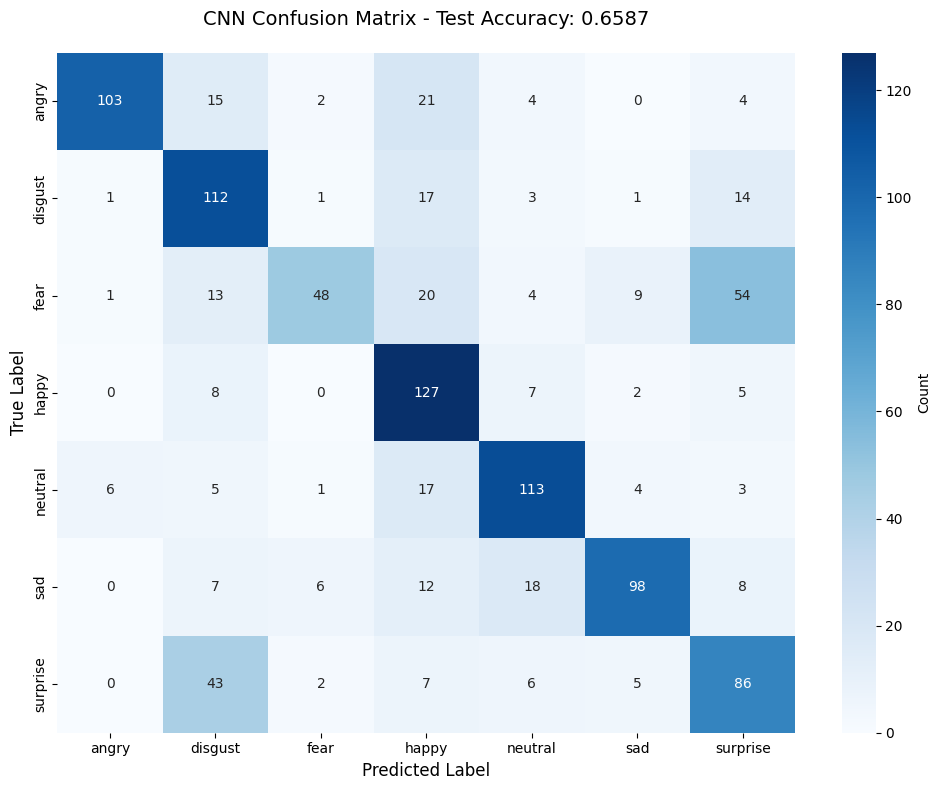


Confusion matrix saved as 'cnn_confusion_matrix.png'


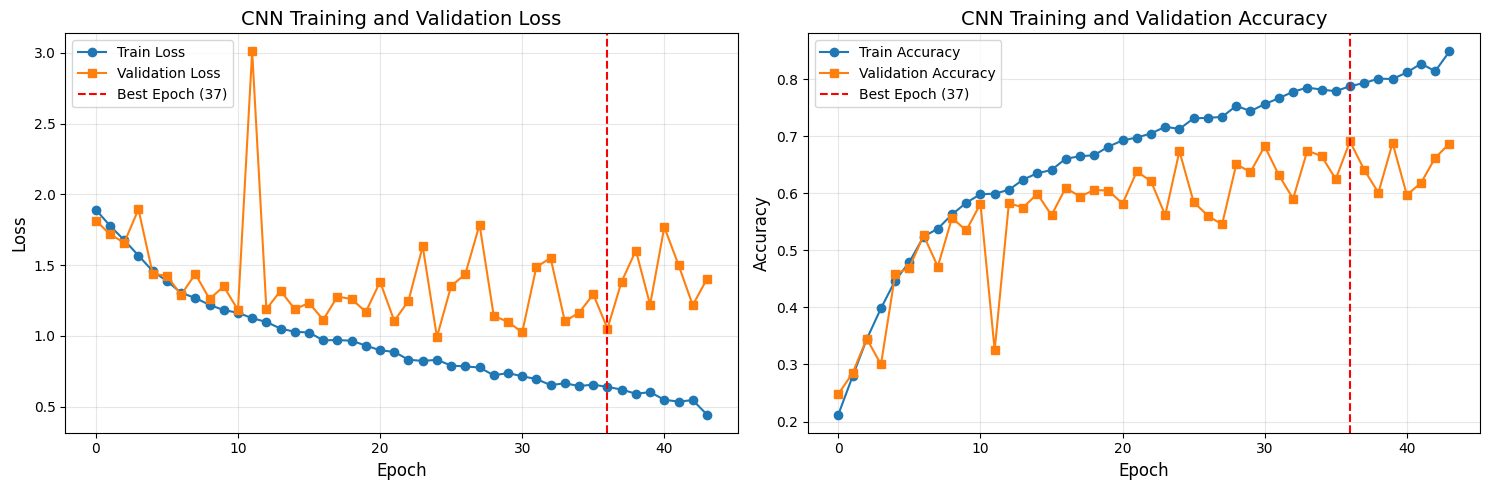

Training history saved as 'cnn_training_history.png'


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


print("\n" + "="*50)
print("Evaluating CNN on Test Set")
print("="*50)

test_loss, test_acc, test_predictions, test_true_labels = validate_cnn(
    cnn_model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


print("\n" + "="*50)
print("CNN Classification Report")
print("="*50)
print(classification_report(
    test_true_labels, 
    test_predictions, 
    target_names=EMOTIONS,
    digits=4
))


cm = confusion_matrix(test_true_labels, test_predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cbar_kws={'label': 'Count'}
)
plt.title(f'CNN Confusion Matrix - Test Accuracy: {test_acc:.4f}', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'cnn_confusion_matrix.png'")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('CNN Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
ax2.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('CNN Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved as 'cnn_training_history.png'")

In [8]:

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_true_labels, test_predictions
)

results_df = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

results_df = results_df.round(4)
print("\n" + "="*50)
print("CNN Per-Class Metrics")
print("="*50)
print(results_df.to_string(index=False))


results_df.to_csv('cnn_per_class_results.csv', index=False)
print("\nPer-class results saved to 'cnn_per_class_results.csv'")


summary = {
    'model_type': 'CNN',
    'num_emotions': len(EMOTIONS),
    'emotions': EMOTIONS,
    'total_epochs': len(history['train_loss']),
    'best_epoch': best_epoch,
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'best_val_accuracy': best_val_accuracy,
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mels': N_MELS,
        'n_fft': N_FFT,
        'hop_length': HOP_LENGTH
    },
    'model_parameters': sum(p.numel() for p in cnn_model.parameters())
}


with open('cnn_training_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print("\nTraining summary saved to 'cnn_training_summary.pkl'")


print("\n" + "="*50)
print("CNN FINAL SUMMARY")
print("="*50)
print(f"Model: CNN (Custom Architecture)")
print(f"Total Parameters: {summary['model_parameters']:,}")
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("\nDataset Split:")
print(f"  Training: {len(y_train)} samples ({len(y_train)/len(labels)*100:.1f}%)")
print(f"  Validation: {len(y_val)} samples ({len(y_val)/len(labels)*100:.1f}%)")
print(f"  Test: {len(y_test)} samples ({len(y_test)/len(labels)*100:.1f}%)")
print("\nInput Configuration:")
print(f"  Sample Rate: {SAMPLE_RATE} Hz")
print(f"  Duration: {DURATION} seconds")
print(f"  Mel Bands: {N_MELS}")
print(f"  FFT Size: {N_FFT}")
print(f"  Hop Length: {HOP_LENGTH}")
print("\nFiles saved:")
print("  - best_cnn_emotion_model.pth (best model checkpoint)")
print("  - cnn_confusion_matrix.png")
print("  - cnn_training_history.png")
print("  - cnn_per_class_results.csv")
print("  - cnn_training_summary.pkl")
print("="*50)


predictions_df = pd.DataFrame({
    'True_Label': [EMOTIONS[i] for i in test_true_labels],
    'Predicted_Label': [EMOTIONS[i] for i in test_predictions],
    'True_Label_Index': test_true_labels,
    'Predicted_Label_Index': test_predictions,
    'Correct': [t == p for t, p in zip(test_true_labels, test_predictions)]
})

predictions_df.to_csv('cnn_test_predictions.csv', index=False)
print("\nTest predictions saved to 'cnn_test_predictions.csv'")


cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
print(pd.DataFrame(cm_percent, index=EMOTIONS, columns=EMOTIONS).round(2))


CNN Per-Class Metrics
 Emotion  Precision  Recall  F1-Score  Support
   angry     0.9279  0.6913    0.7923      149
 disgust     0.5517  0.7517    0.6364      149
    fear     0.8000  0.3221    0.4593      149
   happy     0.5747  0.8523    0.6865      149
 neutral     0.7290  0.7584    0.7434      149
     sad     0.8235  0.6577    0.7313      149
surprise     0.4943  0.5772    0.5325      149

Per-class results saved to 'cnn_per_class_results.csv'

Training summary saved to 'cnn_training_summary.pkl'

CNN FINAL SUMMARY
Model: CNN (Custom Architecture)
Total Parameters: 1,716,871
Total Epochs Trained: 44
Best Epoch: 37
Best Validation Accuracy: 0.6913
Test Accuracy: 0.6587
Test Loss: 1.3564

Dataset Split:
  Training: 3129 samples (60.0%)
  Validation: 1043 samples (20.0%)
  Test: 1043 samples (20.0%)

Input Configuration:
  Sample Rate: 16000 Hz
  Duration: 3 seconds
  Mel Bands: 128
  FFT Size: 2048
  Hop Length: 512

Files saved:
  - best_cnn_emotion_model.pth (best model checkpoi